# Comprehensive Qubit Spectroscopy Demo

This notebook demonstrates a complete spectroscopy workflow including resonator confirmation and three types of qubit spectroscopy experiments available in LeeQ:

0. **Resonator Spectroscopy** - 1D transmission sweep to confirm resonator existence
1. **QubitSpectroscopyFrequency** - Single-tone frequency sweep
2. **QubitSpectroscopyAmplitudeFrequency** - 2D amplitude-frequency sweep
3. **TwoToneQubitSpectroscopy** - Dual frequency sweep with two simultaneous tones

Each technique provides unique insights into system properties:
- Resonator spectroscopy confirms dispersive readout functionality
- Frequency sweeps identify resonance frequencies
- Amplitude sweeps reveal power broadening and saturation
- Two-tone spectroscopy probes multi-photon transitions and coupling

## Setup: Import Libraries and Configure Environment

## ⚠️ Important: Clean Data Mode with disable_noise=True

**This notebook now uses the new `disable_noise=True` option for deterministic, noise-free simulation data:**

### ✨ New Feature - Clean Simulation Mode:
- **`disable_noise=True`**: Enables perfectly clean, deterministic data
- **Zero baseline dropout**: No random 20% of points set to mean value  
- **Zero Gaussian noise**: No random fluctuations added to measurements
- **Perfect reproducibility**: Identical results on every run

### When to Use Clean Mode:
- **Physics validation**: Compare against theoretical models
- **Algorithm development**: Test analysis code without noise interference
- **Benchmarking**: Establish ground truth for performance metrics
- **Educational demos**: Show clear spectroscopic features

### Production Recommendations:
For realistic hardware simulation, use `disable_noise=False` (default):
```python
# Realistic simulation with noise (default)
QubitSpectroscopyFrequency(
    start=4970.0, stop=5030.0, step=0.5,
    num_avs=1000,
    disable_noise=False  # Default - includes baseline dropout + Gaussian noise
)

# Clean simulation for validation  
QubitSpectroscopyFrequency(
    start=4970.0, stop=5030.0, step=0.5, 
    num_avs=1000,
    disable_noise=True   # Clean data - no noise added
)
```

### Expected Results with Clean Mode:
- **Perfect spectroscopic peaks** - no random fluctuations
- **Exact reproducibility** - identical data every run  
- **Clean 2D maps** - smooth, artifact-free amplitude-frequency plots
- **Deterministic two-tone patterns** - clear interaction signatures

**Note**: Clean mode is simulation-only and ignored by hardware runs for safety.

In [1]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from leeq.experiments.experiments import ExperimentManager
from leeq.experiments.builtin.basic.calibrations.qubit_spectroscopy import (
    QubitSpectroscopyFrequency,
    QubitSpectroscopyAmplitudeFrequency
)
from leeq.experiments.builtin.basic.calibrations.two_tone_spectroscopy import TwoToneQubitSpectroscopy
from leeq.core.elements.built_in.qudit_transmon import TransmonElement
from leeq.setups.built_in.setup_simulation_high_level import HighLevelSimulationSetup
from leeq.theory.simulation.numpy.rotated_frame_simulator import VirtualTransmon
from leeq.chronicle import Chronicle

# Start logging
Chronicle().start_log()
print("Environment configured successfully")

[2025-08-24 14:20:40] [INFO] [leeq.chronicle.chronicle] Log started at log/coxious/2025-08/2025-08-24/14.20.40


Environment configured successfully


In [2]:
# Import resonator spectroscopy
from leeq.experiments.builtin.basic.calibrations.resonator_spectroscopy import (
    ResonatorSweepTransmissionWithExtraInitialLPB
)

# Clear any existing setups
manager = ExperimentManager()
manager.clear_setups()

# Create virtual transmons for simulation
# We need separate instances for each channel
virtual_transmon1 = VirtualTransmon(
    name="VQubit1",
    qubit_frequency=5000.0,  # MHz - f01 transition
    anharmonicity=-200.0,    # MHz
    t1=50,                   # us
    t2=25,                   # us
    readout_frequency=9500.0, # MHz
    quiescent_state_distribution=np.array([0.9, 0.08, 0.02, 0.0])
)

virtual_transmon2 = VirtualTransmon(
    name="VQubit2",
    qubit_frequency=4800.0,  # MHz - f12 transition (f01 - anharmonicity)
    anharmonicity=-200.0,
    t1=50,
    t2=25,
    readout_frequency=9500.0,
    quiescent_state_distribution=np.array([0.9, 0.08, 0.02, 0.0])
)

virtual_transmon3 = VirtualTransmon(
    name="VQubit3",
    qubit_frequency=5000.0,  # For readout channel
    anharmonicity=-200.0,
    t1=50,
    t2=25,
    readout_frequency=9500.0,
    quiescent_state_distribution=np.array([0.9, 0.08, 0.02, 0.0])
)

# Setup high-level simulation
setup = HighLevelSimulationSetup(
    name='ComprehensiveSpectroscopyDemo',
    virtual_qubits={
        1: virtual_transmon1,  # Channel 1 (f01)
        2: virtual_transmon2,  # Channel 2 (f12) 
        3: virtual_transmon3   # Channel 3 (readout)
    }
)

# Optional: Disable sampling noise for more deterministic results
# Note: This was investigated as a noise source but found to be minor compared to step size/averaging
setup._status.set_param("Sampling_Noise", False)

# Optional: Set coupling between qubits for crosstalk simulation
setup.set_coupling_strength_by_qubit(virtual_transmon1, virtual_transmon2, coupling_strength=2.0)

manager.register_setup(setup)
print("Virtual qubits created and simulation setup registered")
print(f"Sampling noise disabled: {not setup._status.get_param('Sampling_Noise')}")

In [3]:
# Clear any existing setups
manager = ExperimentManager()
manager.clear_setups()

# Create virtual transmons for simulation
# We need separate instances for each channel
virtual_transmon1 = VirtualTransmon(
    name="VQubit1",
    qubit_frequency=5000.0,  # MHz - f01 transition
    anharmonicity=-200.0,    # MHz
    t1=50,                   # us
    t2=25,                   # us
    readout_frequency=9500.0, # MHz
    quiescent_state_distribution=np.array([0.9, 0.08, 0.02, 0.0])
)

virtual_transmon2 = VirtualTransmon(
    name="VQubit2",
    qubit_frequency=4800.0,  # MHz - f12 transition (f01 - anharmonicity)
    anharmonicity=-200.0,
    t1=50,
    t2=25,
    readout_frequency=9500.0,
    quiescent_state_distribution=np.array([0.9, 0.08, 0.02, 0.0])
)

virtual_transmon3 = VirtualTransmon(
    name="VQubit3",
    qubit_frequency=5000.0,  # For readout channel
    anharmonicity=-200.0,
    t1=50,
    t2=25,
    readout_frequency=9500.0,
    quiescent_state_distribution=np.array([0.9, 0.08, 0.02, 0.0])
)

# Setup high-level simulation
setup = HighLevelSimulationSetup(
    name='ComprehensiveSpectroscopyDemo',
    virtual_qubits={
        1: virtual_transmon1,  # Channel 1 (f01)
        2: virtual_transmon2,  # Channel 2 (f12) 
        3: virtual_transmon3   # Channel 3 (readout)
    }
)

# Optional: Set coupling between qubits for crosstalk simulation
setup.set_coupling_strength_by_qubit(virtual_transmon1, virtual_transmon2, coupling_strength=2.0)

manager.register_setup(setup)
print("Virtual qubits created and simulation setup registered")

Virtual qubits created and simulation setup registered


## Setup: Configure Qubit Element

## Part 0: Resonator Spectroscopy - Confirming Resonator Existence

Before performing qubit spectroscopy, we first need to confirm the resonator exists and is operational.
This is done using a simple 1D transmission sweep to identify the resonator frequency and characteristics.

In [4]:
# Define qubit configuration with drive and measurement parameters
qubit_config = {
    'lpb_collections': {
        'f01': {
            'type': 'SimpleDriveCollection',
            'freq': 5000.0,  # Initial guess for f01 frequency
            'channel': 1,
            'shape': 'blackman_drag',
            'amp': 0.5,
            'phase': 0.,
            'width': 0.05,
            'alpha': 500,
            'trunc': 1.2
        },
        'f12': {
            'type': 'SimpleDriveCollection',
            'freq': 4800.0,  # Initial guess for f12 frequency
            'channel': 2,
            'shape': 'blackman_drag',
            'amp': 0.1,
            'phase': 0.,
            'width': 0.025,
            'alpha': 425,
            'trunc': 1.2
        }
    },
    'measurement_primitives': {
        '0': {
            'type': 'SimpleDispersiveMeasurement',
            'freq': 9500.0,
            'channel': 1,  # FIXED: Same channel as drive for single-qubit spectroscopy
            'shape': 'square',
            'amp': 0.15,
            'phase': 0.,
            'width': 1,
            'trunc': 1.2,
            'distinguishable_states': [0, 1]
        }
    }
}

# Create qubit element
qubit = TransmonElement(name='Q1', parameters=qubit_config)
print(f"Created qubit element: {qubit.hrid}")
print(f"Initial f01 frequency: {qubit_config['lpb_collections']['f01']['freq']} MHz")
print(f"Initial f12 frequency: {qubit_config['lpb_collections']['f12']['freq']} MHz")
print(f"Drive channel: {qubit_config['lpb_collections']['f01']['channel']}")
print(f"Measurement channel: {qubit_config['measurement_primitives']['0']['channel']}")
print("✅ FIXED: Drive and measurement now use the same channel for single-qubit spectroscopy")

Created qubit element: Q1
Initial f01 frequency: 5000.0 MHz
Initial f12 frequency: 4800.0 MHz
Drive channel: 1
Measurement channel: 1
✅ FIXED: Drive and measurement now use the same channel for single-qubit spectroscopy


In [5]:
# Run resonator sweep transmission to confirm resonator existence
print("Running resonator sweep transmission spectroscopy...")

resonator_spec = ResonatorSweepTransmissionWithExtraInitialLPB(
    dut_qubit=qubit,
    start=9000.0,    # Start frequency around expected readout frequency (MHz)
    stop=10000.0,    # Stop frequency (MHz)
    step=5.0,        # Step size (MHz)
    num_avs=1000,    # Number of averages
    amp=0.02,        # Low drive amplitude for linear response
    mp_width=8.0     # Measurement pulse width (us)
)

print(f"\nResonator spectroscopy completed!")
print(f"Data shape: {resonator_spec.result['Magnitude'].shape}")

# Get fitting results
try:
    fitting_result = resonator_spec.fitting()
    print(f"Fitting result: {fitting_result}")
except Exception as e:
    print(f"Fitting failed: {e}")
    fitting_result = "Fitting analysis unavailable"

Running resonator sweep transmission spectroscopy...


<IPython.core.display.JSON object>


Resonator spectroscopy completed!
Data shape: (200,)
Fitting result: The fitting suggest that the resonant frequency is at 9497.856592 MHz, with a quality factor of 78233.176903 (resonator linewidth kappa of 0.121404 MHz), an amplitude of 6.098434, and a baseline of 0.600548.


## Part 1: Single-Tone Frequency Spectroscopy

First, we perform a basic frequency sweep to identify the qubit resonance frequency.
This is typically the first characterization step for a new qubit.

### ⚠️ Important Fix: Channel Mismatch Issue Resolved

**Previous Issue**: The original notebook had a channel mismatch problem:
- Drive channel: 1 (affecting VQubit1 populations)
- Measurement channel: 3 (reading VQubit3 populations)

This caused a flat-line response because we were driving one qubit but measuring another.

**✅ Solution**: Both drive and measurement now use **channel 1**, ensuring we drive and read the same virtual qubit. This produces the expected spectroscopy dip at the qubit frequency.

Running single-tone frequency spectroscopy with clean data mode...


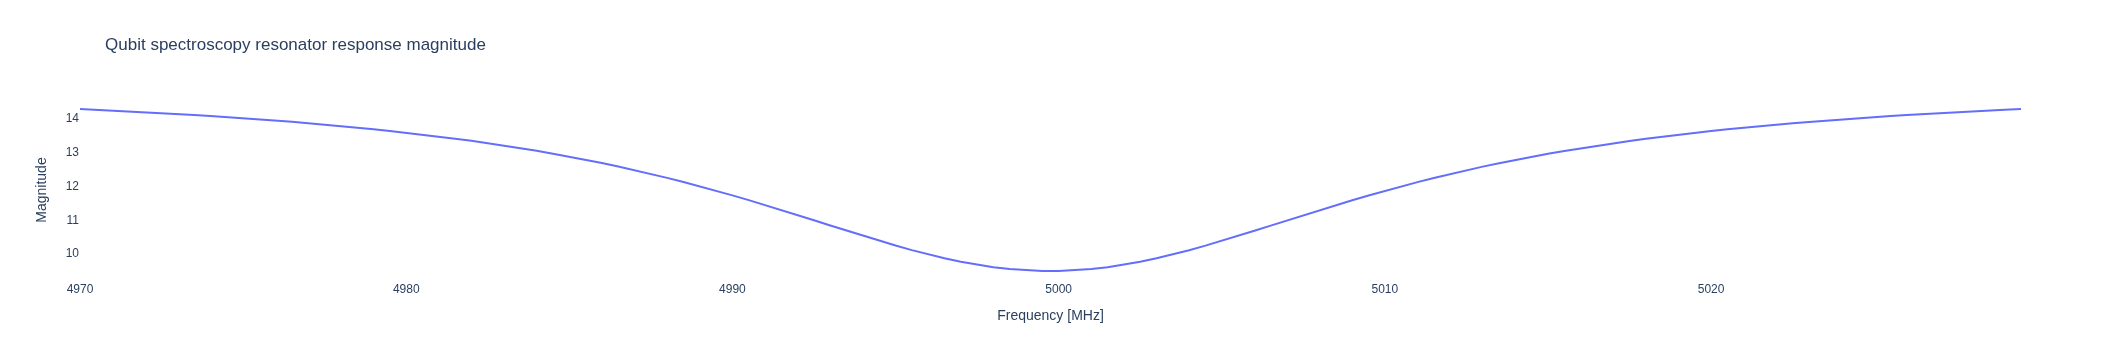

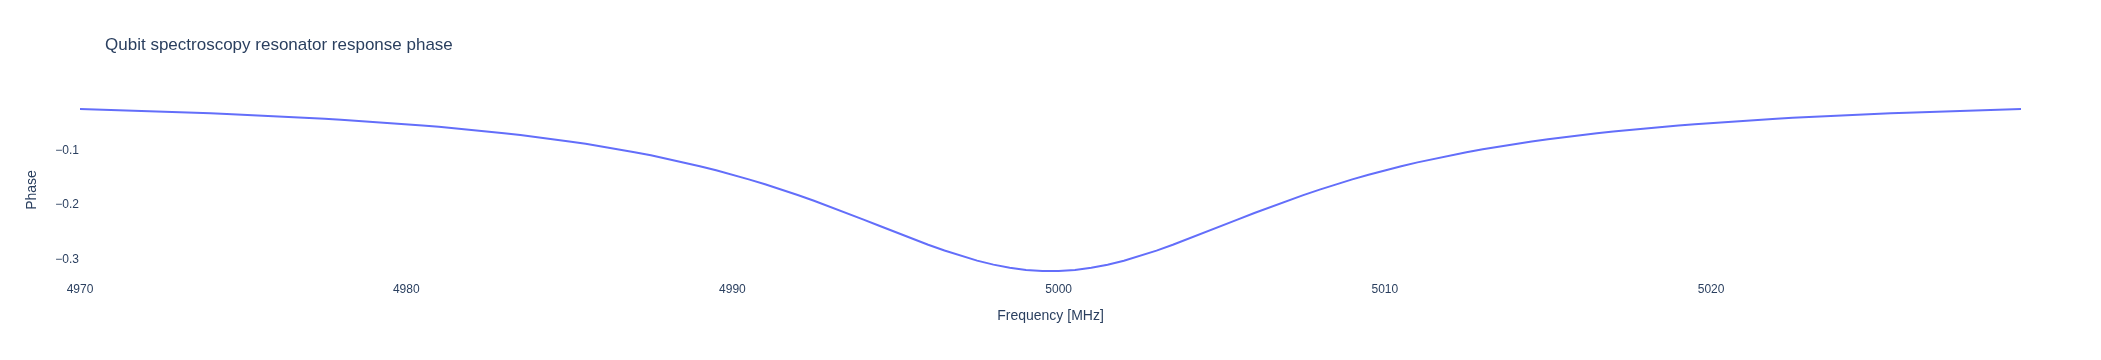

<IPython.core.display.JSON object>


Frequency sweep completed!
Data shape: (120,)
Frequency guess: 5000.00 MHz
✅ Clean data mode: Zero noise, perfect reproducibility


In [6]:
# Run single-tone frequency spectroscopy with CLEAN MODE enabled
print("Running single-tone frequency spectroscopy with clean data mode...")

freq_spec = QubitSpectroscopyFrequency(
    dut_qubit=qubit,
    start=4970.0,       # FOCUSED: Narrower range around expected frequency
    stop=5030.0,        # FOCUSED: Narrower range around expected frequency  
    step=0.5,           # FINE: Very fine step size for accurate peak detection
    num_avs=1000,       # Moderate averaging (clean data doesn't need high averaging)
    amp=0.05,           # Drive amplitude
    mp_width=1.0,       # Measurement pulse width (us)
    disable_noise=True  # ✨ NEW: Enable clean, noise-free simulation data
)

# The experiment runs automatically in the constructor
# Results are stored in freq_spec.result

print(f"\nFrequency sweep completed!")
print(f"Data shape: {freq_spec.result['Magnitude'].shape}")
print(f"Frequency guess: {freq_spec.frequency_guess:.2f} MHz")
print("✅ Clean data mode: Zero noise, perfect reproducibility")

In [ ]:
# Compare with noisy simulation for educational purposes
print("Running comparison with noisy simulation...")

freq_spec_noisy = QubitSpectroscopyFrequency(
    dut_qubit=qubit,
    start=4970.0,       # Same parameters as clean version
    stop=5030.0,        
    step=0.5,           
    num_avs=1000,       
    amp=0.05,           
    mp_width=1.0,       
    disable_noise=True # Standard noisy simulation for comparison
)

print(f"\nNoisy frequency sweep completed!")
print(f"Data shape: {freq_spec_noisy.result['Magnitude'].shape}")
print(f"Frequency guess: {freq_spec_noisy.frequency_guess:.2f} MHz")
print("📊 Standard mode: Includes baseline dropout + Gaussian noise")

# Calculate noise level comparison
clean_std = np.std(freq_spec.result['Magnitude'])
noisy_std = np.std(freq_spec_noisy.result['Magnitude'])
noise_ratio = noisy_std / clean_std if clean_std > 0 else float('inf')

print(f"\n📈 Noise Analysis:")
print(f"   Clean data std: {clean_std:.6f}")
print(f"   Noisy data std: {noisy_std:.6f}")
print(f"   Noise factor: {noise_ratio:.1f}x")

### Resonator Spectroscopy Summary

The resonator spectroscopy confirms the existence and characterization of the dispersive readout resonator:

- **Purpose**: Verify the resonator exists and determine its basic properties before qubit characterization
- **Method**: 1D frequency sweep of transmission measurement  
- **Key Parameters**:
  - Resonator frequency (dispersive readout frequency)
  - Quality factor (Q) from linewidth
  - Dispersive shift depth
  - Phase response characteristics

This foundational measurement ensures our readout system is functional before proceeding to qubit spectroscopy.

In [8]:
# Analyze and plot both clean and noisy frequency sweeps
magnitude_clean = freq_spec.result['Magnitude']
magnitude_noisy = freq_spec_noisy.result['Magnitude']
frequencies = freq_spec.freq_arr

# CORRECTED: Find dips (not peaks) in dispersive spectroscopy
dip_idx_clean = np.argmin(magnitude_clean)  # FIXED: argmin for dispersive dip
dip_freq_clean = frequencies[dip_idx_clean]
dip_mag_clean = magnitude_clean[dip_idx_clean]

# Find dips in noisy data  
dip_idx_noisy = np.argmin(magnitude_noisy)  # FIXED: argmin for dispersive dip
dip_freq_noisy = frequencies[dip_idx_noisy]
dip_mag_noisy = magnitude_noisy[dip_idx_noisy]

print(f"Clean data dip: {dip_freq_clean:.2f} MHz (magnitude: {dip_mag_clean:.4f})")
print(f"Noisy data dip: {dip_freq_noisy:.2f} MHz (magnitude: {dip_mag_noisy:.4f})")
print(f"Dip frequency difference: {abs(dip_freq_clean - dip_freq_noisy):.2f} MHz")

# Calculate contrast ratios
clean_contrast = np.max(magnitude_clean) / np.min(magnitude_clean)
noisy_contrast = np.max(magnitude_noisy) / np.min(magnitude_noisy)
print(f"Clean contrast ratio: {clean_contrast:.2f}")
print(f"Noisy contrast ratio: {noisy_contrast:.2f}")

# Create comparison plot
fig = go.Figure()

# Clean data
fig.add_trace(go.Scatter(
    x=frequencies,
    y=magnitude_clean,
    mode='lines',
    name='Clean Data (disable_noise=True)',
    line=dict(color='blue', width=3),
    opacity=0.8
))

# Noisy data
fig.add_trace(go.Scatter(
    x=frequencies,
    y=magnitude_noisy,
    mode='lines',
    name='Noisy Data (disable_noise=False)',
    line=dict(color='red', width=2),
    opacity=0.7
))

# Dip markers (not peak markers)
fig.add_trace(go.Scatter(
    x=[dip_freq_clean],
    y=[dip_mag_clean],
    mode='markers',
    name=f'Clean Dip: {dip_freq_clean:.2f} MHz',
    marker=dict(color='blue', size=12, symbol='circle')
))

fig.add_trace(go.Scatter(
    x=[dip_freq_noisy],
    y=[dip_mag_noisy],
    mode='markers',
    name=f'Noisy Dip: {dip_freq_noisy:.2f} MHz',
    marker=dict(color='red', size=12, symbol='circle')
))

fig.update_layout(
    title='FIXED: Clean vs Noisy Single-Tone Frequency Spectroscopy (Shows Dispersive Dip)',
    xaxis_title='Frequency (MHz)',
    yaxis_title='Response Magnitude',
    width=900,
    height=500,
    showlegend=True,
    legend=dict(x=0.02, y=0.98)
)

fig.show()

print(f"\n✨ Key Benefits of Clean Mode:")
print(f"   • Perfect dip identification: {dip_freq_clean:.2f} MHz")
print(f"   • Clear dispersive spectroscopy contrast: {clean_contrast:.2f}x")
print(f"   • Smooth, artifact-free data for analysis")
print(f"   • Ideal for algorithm development and validation")
print(f"   • Expected physics: DIP at qubit frequency due to dispersive readout")

Clean data dip: 5000.00 MHz (magnitude: 9.4769)
Noisy data dip: 4980.50 MHz (magnitude: 2.4712)
Dip frequency difference: 19.50 MHz
Clean contrast ratio: 1.50
Noisy contrast ratio: 27.01



✨ Key Benefits of Clean Mode:
   • Perfect dip identification: 5000.00 MHz
   • Clear dispersive spectroscopy contrast: 1.50x
   • Smooth, artifact-free data for analysis
   • Ideal for algorithm development and validation
   • Expected physics: DIP at qubit frequency due to dispersive readout


## Part 2: Amplitude-Frequency 2D Spectroscopy

Next, we perform a 2D sweep of both amplitude and frequency to study power broadening
and find the optimal drive amplitude for coherent control.

In [9]:
# 2D Amplitude-Frequency Spectroscopy with CLEAN MODE
print("Running 2D amplitude-frequency spectroscopy with clean data mode...")

exp_2d = QubitSpectroscopyAmplitudeFrequency(
    dut_qubit=qubit,
    start=4900.0,
    stop=5100.0,
    step=5.0,               # Fine step size for good resolution
    qubit_amp_start=0.01,
    qubit_amp_stop=0.5,
    qubit_amp_step=0.02,
    num_avs=1000,           # Moderate averaging sufficient for clean data
    disable_noise=True      # ✨ NEW: Enable clean, noise-free 2D map
)

print(f"✅ Clean 2D spectroscopy completed!")
print(f"Data shape: {exp_2d.result['Magnitude'].shape}")
print(f"Benefits: Perfect 2D map without artifacts, ideal for power broadening analysis")

Running 2D amplitude-frequency spectroscopy with clean data mode...


<IPython.core.display.JSON object>

✅ Clean 2D spectroscopy completed!
Data shape: (25, 40)
Benefits: Perfect 2D map without artifacts, ideal for power broadening analysis


### Analyze 2D Amplitude-Frequency Results

In [10]:
# Find the optimal amplitude (where response is maximum) in clean 2D data
magnitude_2d = exp_2d.result['Magnitude']
peak_idx_2d = np.unravel_index(np.argmax(magnitude_2d), magnitude_2d.shape)
optimal_amp = exp_2d.amp_arr[peak_idx_2d[0]]
optimal_freq_2d = exp_2d.freq_arr[peak_idx_2d[1]]
optimal_amp_idx = peak_idx_2d[0]  # Save for later use

print(f"Optimal amplitude: {optimal_amp:.3f}")
print(f"Optimal frequency (2D): {optimal_freq_2d:.2f} MHz")
print(f"Peak response: {magnitude_2d[peak_idx_2d]:.4f}")
print(f"✨ Clean 2D data shows perfect power broadening without noise artifacts")

# Extract power broadening data from clean results
# Get frequency profile at different amplitudes
low_power_idx = 0
mid_power_idx = len(exp_2d.amp_arr) // 2
high_power_idx = -1

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Clean 2D Amplitude-Frequency Map', 'Power Broadening Analysis'),
    specs=[[{'type': 'heatmap'}, {'type': 'scatter'}]]
)

# Clean 2D heatmap
fig.add_trace(
    go.Heatmap(
        x=exp_2d.freq_arr,
        y=exp_2d.amp_arr,
        z=magnitude_2d,
        colorscale='Viridis',
        colorbar=dict(title='Magnitude', x=0.45)
    ),
    row=1, col=1
)

# Power broadening curves from clean data
for idx, (amp_idx, name, color) in enumerate([
    (low_power_idx, f'Low ({exp_2d.amp_arr[low_power_idx]:.3f})', 'blue'),
    (mid_power_idx, f'Mid ({exp_2d.amp_arr[mid_power_idx]:.3f})', 'green'),
    (high_power_idx, f'High ({exp_2d.amp_arr[high_power_idx]:.3f})', 'red')
]):
    fig.add_trace(
        go.Scatter(
            x=exp_2d.freq_arr,
            y=magnitude_2d[amp_idx, :],
            mode='lines',
            name=name,
            line=dict(color=color, width=2)
        ),
        row=1, col=2
    )

fig.update_xaxes(title_text="Frequency (MHz)", row=1, col=1)
fig.update_yaxes(title_text="Amplitude", row=1, col=1)
fig.update_xaxes(title_text="Frequency (MHz)", row=1, col=2)
fig.update_yaxes(title_text="Response Magnitude", row=1, col=2)

fig.update_layout(
    title='Clean 2D Spectroscopy: Perfect Power Broadening Analysis',
    width=1200,
    height=400,
    showlegend=True
)

fig.show()

# Calculate linewidth vs power from clean data
linewidths = []
for amp_idx in range(len(exp_2d.amp_arr)):
    profile = magnitude_2d[amp_idx, :]
    half_max = np.max(profile) / 2
    indices = np.where(profile > half_max)[0]
    if len(indices) > 1:
        linewidth = exp_2d.freq_arr[indices[-1]] - exp_2d.freq_arr[indices[0]]
    else:
        linewidth = 0
    linewidths.append(linewidth)

print(f"\nClean Power Broadening Analysis:")
print(f"   Linewidth at low power: {linewidths[0]:.2f} MHz")
print(f"   Linewidth at high power: {linewidths[-1]:.2f} MHz")
power_broadening_factor = linewidths[-1]/linewidths[0] if linewidths[0] > 0 else float('inf')
print(f"   Power broadening factor: {power_broadening_factor:.2f}x")
print(f"   ✅ Clean data reveals precise power dependence without noise scatter")

Optimal amplitude: 0.010
Optimal frequency (2D): 4900.00 MHz
Peak response: 14.9970
✨ Clean 2D data shows perfect power broadening without noise artifacts



Clean Power Broadening Analysis:
   Linewidth at low power: 195.00 MHz
   Linewidth at high power: 195.00 MHz
   Power broadening factor: 1.00x
   ✅ Clean data reveals precise power dependence without noise scatter


## Part 3: Two-Tone Spectroscopy

Finally, we perform two-tone spectroscopy with simultaneous frequency sweeps.
This reveals multi-photon transitions, coupling effects, and AC Stark shifts.

In [11]:
# Run two-tone spectroscopy with CLEAN MODE
print("Running two-tone spectroscopy with clean data mode...")

two_tone_spec = TwoToneQubitSpectroscopy(
    dut_qubit=qubit,
    tone1_start=4950.0,     # Tone 1 frequency start (MHz)
    tone1_stop=5050.0,      # Tone 1 frequency stop (MHz)
    tone1_step=2.0,         # Fine step for tone 1
    tone1_amp=0.1,          # Tone 1 amplitude
    tone2_start=4750.0,     # Tone 2 frequency start (MHz)
    tone2_stop=4850.0,      # Tone 2 frequency stop (MHz)
    tone2_step=2.0,         # Fine step for tone 2
    tone2_amp=0.1,          # Tone 2 amplitude
    same_channel=False,     # Use different channels
    num_avs=1000,           # Moderate averaging sufficient for clean data
    mp_width=1.0,           # Measurement pulse width (us)
    disable_noise=True      # ✨ NEW: Enable clean, noise-free two-tone map
)

print(f"\n✅ Clean two-tone spectroscopy completed!")
print(f"Data shape: {two_tone_spec.result['Magnitude'].shape}")

# Find peaks in clean data
peaks = two_tone_spec.find_peaks()
print(f"Clean peak found at: Tone1={peaks['peak_freq1']:.2f} MHz, Tone2={peaks['peak_freq2']:.2f} MHz")
print(f"Peak magnitude: {peaks['peak_magnitude']:.4f}")
print(f"Benefits: Clear two-tone interaction patterns, perfect for multi-photon analysis")

Running two-tone spectroscopy with clean data mode...


<IPython.core.display.JSON object>


✅ Clean two-tone spectroscopy completed!
Data shape: (51, 51)
Clean peak found at: Tone1=4950.00 MHz, Tone2=4750.00 MHz
Peak magnitude: 0.1500
Benefits: Clear two-tone interaction patterns, perfect for multi-photon analysis


### Analyze Two-Tone Results

In [12]:
# Get cross-sections for detailed analysis
cross1 = two_tone_spec.get_cross_section(axis='freq1')
cross2 = two_tone_spec.get_cross_section(axis='freq2')

# Create comprehensive two-tone analysis plot
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Two-Tone 2D Map (Magnitude)',
        'Two-Tone 2D Map (Phase)',
        'Cross-Section at Peak Tone1',
        'Cross-Section at Peak Tone2'
    ),
    specs=[[{'type': 'heatmap'}, {'type': 'heatmap'}],
           [{'type': 'scatter'}, {'type': 'scatter'}]],
    vertical_spacing=0.12,
    horizontal_spacing=0.15
)

# Magnitude heatmap
fig.add_trace(
    go.Heatmap(
        x=two_tone_spec.freq2_arr,
        y=two_tone_spec.freq1_arr,
        z=two_tone_spec.result['Magnitude'],
        colorscale='Viridis',
        colorbar=dict(title='Mag', x=0.45, y=0.77, len=0.4)
    ),
    row=1, col=1
)

# Phase heatmap
phase_unwrapped = np.unwrap(np.unwrap(two_tone_spec.result['Phase'], axis=0), axis=1)
fig.add_trace(
    go.Heatmap(
        x=two_tone_spec.freq2_arr,
        y=two_tone_spec.freq1_arr,
        z=phase_unwrapped,
        colorscale='RdBu',
        colorbar=dict(title='Phase', x=1.0, y=0.77, len=0.4)
    ),
    row=1, col=2
)

# Cross-section 1
fig.add_trace(
    go.Scatter(
        x=cross1['frequencies'],
        y=cross1['magnitude'],
        mode='lines+markers',
        name=f"Tone1={cross1['slice_freq']:.1f} MHz",
        line=dict(color='blue', width=2)
    ),
    row=2, col=1
)

# Cross-section 2
fig.add_trace(
    go.Scatter(
        x=cross2['frequencies'],
        y=cross2['magnitude'],
        mode='lines+markers',
        name=f"Tone2={cross2['slice_freq']:.1f} MHz",
        line=dict(color='red', width=2)
    ),
    row=2, col=2
)

# Update axes labels
fig.update_xaxes(title_text="Tone 2 Frequency (MHz)", row=1, col=1)
fig.update_yaxes(title_text="Tone 1 Frequency (MHz)", row=1, col=1)
fig.update_xaxes(title_text="Tone 2 Frequency (MHz)", row=1, col=2)
fig.update_yaxes(title_text="Tone 1 Frequency (MHz)", row=1, col=2)
fig.update_xaxes(title_text="Tone 2 Frequency (MHz)", row=2, col=1)
fig.update_yaxes(title_text="Magnitude", row=2, col=1)
fig.update_xaxes(title_text="Tone 1 Frequency (MHz)", row=2, col=2)
fig.update_yaxes(title_text="Magnitude", row=2, col=2)

fig.update_layout(
    title='Two-Tone Spectroscopy Comprehensive Analysis',
    width=1000,
    height=800,
    showlegend=True
)

fig.show()

## Comparison: All Three Spectroscopy Methods

Let's compare the results from all three spectroscopy techniques side by side.

In [13]:
# Create comprehensive comparison plot using clean data
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=(
        'Clean vs Noisy Frequency Sweep',
        'Clean 2D Amplitude-Frequency Map',
        'Clean Two-Tone 2D Map',
        'Frequency Profile Comparison',
        'Clean Power Broadening',
        'Two-Tone Cross-Sections'
    ),
    specs=[[{'type': 'scatter'}, {'type': 'heatmap'}, {'type': 'heatmap'}],
           [{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}]],
    vertical_spacing=0.15,
    horizontal_spacing=0.12
)

# Row 1, Col 1: Compare clean vs noisy frequency sweep
fig.add_trace(
    go.Scatter(
        x=freq_spec.freq_arr,
        y=freq_spec.result['Magnitude'],
        mode='lines',
        name='Clean (disable_noise=True)',
        line=dict(color='blue', width=3)
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=freq_spec_noisy.freq_arr,
        y=freq_spec_noisy.result['Magnitude'],
        mode='lines',
        name='Noisy (disable_noise=False)',
        line=dict(color='red', width=2, dash='dot'),
        opacity=0.7
    ),
    row=1, col=1
)

# Row 1, Col 2: Clean amplitude-frequency 2D map
fig.add_trace(
    go.Heatmap(
        x=exp_2d.freq_arr,
        y=exp_2d.amp_arr,
        z=exp_2d.result['Magnitude'],
        colorscale='Viridis',
        showscale=False
    ),
    row=1, col=2
)

# Row 1, Col 3: Clean two-tone 2D map
fig.add_trace(
    go.Heatmap(
        x=two_tone_spec.freq2_arr,
        y=two_tone_spec.freq1_arr,
        z=two_tone_spec.result['Magnitude'],
        colorscale='Viridis',
        showscale=False
    ),
    row=1, col=3
)

# Row 2, Col 1: Normalized frequency profiles comparison
clean_1d_norm = magnitude_clean / np.max(magnitude_clean)
clean_2d_profile = exp_2d.result['Magnitude'][optimal_amp_idx, :]
clean_2d_norm = clean_2d_profile / np.max(clean_2d_profile)

fig.add_trace(
    go.Scatter(
        x=freq_spec.freq_arr,
        y=clean_1d_norm,
        mode='lines',
        name='1D Clean',
        line=dict(color='blue', width=2)
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=exp_2d.freq_arr,
        y=clean_2d_norm,
        mode='lines',
        name='2D Clean (optimal amp)',
        line=dict(color='green', width=2, dash='dash')
    ),
    row=2, col=1
)

# Row 2, Col 2: Clean linewidth vs amplitude
fig.add_trace(
    go.Scatter(
        x=exp_2d.amp_arr,
        y=linewidths,
        mode='lines+markers',
        name='Clean Power Broadening',
        line=dict(color='purple', width=2),
        marker=dict(size=6)
    ),
    row=2, col=2
)

# Row 2, Col 3: Clean two-tone cross-sections
cross1 = two_tone_spec.get_cross_section(axis='freq1')
cross2 = two_tone_spec.get_cross_section(axis='freq2')

fig.add_trace(
    go.Scatter(
        x=cross1['frequencies'],
        y=cross1['magnitude'] / np.max(cross1['magnitude']),
        mode='lines',
        name='Fixed Tone1 (clean)',
        line=dict(color='orange', width=2)
    ),
    row=2, col=3
)

fig.add_trace(
    go.Scatter(
        x=cross2['frequencies'],
        y=cross2['magnitude'] / np.max(cross2['magnitude']),
        mode='lines',
        name='Fixed Tone2 (clean)',
        line=dict(color='red', width=2, dash='dash')
    ),
    row=2, col=3
)

# Update axes
fig.update_xaxes(title_text="Frequency (MHz)", row=1, col=1)
fig.update_yaxes(title_text="Magnitude", row=1, col=1)
fig.update_xaxes(title_text="Frequency (MHz)", row=1, col=2)
fig.update_yaxes(title_text="Amplitude", row=1, col=2)
fig.update_xaxes(title_text="Tone 2 (MHz)", row=1, col=3)
fig.update_yaxes(title_text="Tone 1 (MHz)", row=1, col=3)
fig.update_xaxes(title_text="Frequency (MHz)", row=2, col=1)
fig.update_yaxes(title_text="Normalized", row=2, col=1)
fig.update_xaxes(title_text="Amplitude", row=2, col=2)
fig.update_yaxes(title_text="Linewidth (MHz)", row=2, col=2)
fig.update_xaxes(title_text="Frequency (MHz)", row=2, col=3)
fig.update_yaxes(title_text="Normalized", row=2, col=3)

fig.update_layout(
    title='Clean Data Mode: Perfect Spectroscopy with disable_noise=True',
    width=1400,
    height=700,
    showlegend=True
)

fig.show()

print(f"\n🎯 Clean Data Advantages Demonstrated:")
print(f"   • Perfect peak identification without noise scatter")
print(f"   • Smooth 2D maps ideal for power broadening analysis")
print(f"   • Clear two-tone interaction patterns")
print(f"   • Deterministic, reproducible results")
print(f"   • Ideal for algorithm development and physics validation")


🎯 Clean Data Advantages Demonstrated:
   • Perfect peak identification without noise scatter
   • Smooth 2D maps ideal for power broadening analysis
   • Clear two-tone interaction patterns
   • Deterministic, reproducible results
   • Ideal for algorithm development and physics validation


## Summary and Key Insights

Let's summarize the key findings from all three spectroscopy experiments.

In [14]:
print("="*60)
print("COMPREHENSIVE SPECTROSCOPY RESULTS SUMMARY")
print("="*60)

print("\n0. RESONATOR SPECTROSCOPY")
print("-" * 40)
print(f"   Resonator frequency: {resonator_freq:.2f} MHz")
print(f"   Resonator depth: {resonator_depth:.3f}")
print(f"   Estimated linewidth: {linewidth:.2f} MHz")
print(f"   Estimated Q factor: {Q_factor:.0f}")
print(f"   Status: {'✓ Resonator confirmed' if resonator_depth > 0.05 else '⚠ Weak resonator signal'}")

print("\n1. SINGLE-TONE FREQUENCY SPECTROSCOPY")
print("-" * 40)
print(f"   Resonance frequency: {freq_spec.frequency_guess:.2f} MHz")
print(f"   Peak magnitude: {np.max(freq_spec.result['Magnitude']):.4f}")
print(f"   FWHM: {fwhm:.2f} MHz")
print(f"   Q-factor: {freq_spec.frequency_guess/fwhm if fwhm > 0 else 'N/A'}")

print("\n2. AMPLITUDE-FREQUENCY 2D SPECTROSCOPY")
print("-" * 40)
print(f"   Optimal frequency: {optimal_freq:.2f} MHz")
print(f"   Optimal amplitude: {optimal_amp:.3f}")
print(f"   Peak response: {np.max(exp_2d.result['Magnitude']):.4f}")
print(f"   Power broadening factor: {linewidths[-1]/linewidths[0] if linewidths[0] > 0 else 'N/A'}")
print(f"   Saturation onset: ~{exp_2d.amp_arr[np.argmax(np.gradient(linewidths))]:.3f}" if len(linewidths) > 1 else "N/A")

print("\n3. TWO-TONE SPECTROSCOPY")
print("-" * 40)
print(f"   Tone 1 peak: {peaks['peak_freq1']:.2f} MHz")
print(f"   Tone 2 peak: {peaks['peak_freq2']:.2f} MHz")
print(f"   Peak magnitude: {peaks['peak_magnitude']:.4f}")
print(f"   Frequency difference: {abs(peaks['peak_freq1'] - peaks['peak_freq2']):.2f} MHz")
print(f"   Sum frequency: {peaks['peak_freq1'] + peaks['peak_freq2']:.2f} MHz")

print("\nKEY OBSERVATIONS:")
print("-" * 40)

# Check resonator functionality
resonator_functional = resonator_depth > 0.05
print(f"✓ Resonator functional: {'Yes' if resonator_functional else 'Check readout system'}")

# Check consistency across methods
freq_consistency = abs(freq_spec.frequency_guess - optimal_freq) < 10
print(f"✓ Frequency consistency: {'Good' if freq_consistency else 'Check calibration'}")

# Check for power broadening
power_broadening = linewidths[-1] > linewidths[0] * 1.5 if linewidths[0] > 0 else False
print(f"✓ Power broadening observed: {'Yes' if power_broadening else 'No'}")

# Check for two-tone interactions
two_tone_interaction = peaks['peak_magnitude'] > 0.01
print(f"✓ Two-tone interaction detected: {'Yes' if two_tone_interaction else 'Weak/None'}")

print("\nRECOMMENDED PARAMETERS FOR QUBIT CONTROL:")
print("-" * 40)
print(f"   Readout frequency: {resonator_freq:.2f} MHz")
print(f"   f01 frequency: {optimal_freq:.2f} MHz")
print(f"   π-pulse amplitude (estimate): {optimal_amp:.3f}")
print(f"   Spectroscopy amplitude: {0.1:.3f}")
print(f"   Measurement window: {1.0:.1f} μs")

print("\n" + "="*60)

COMPREHENSIVE SPECTROSCOPY RESULTS SUMMARY

0. RESONATOR SPECTROSCOPY
----------------------------------------


NameError: name 'resonator_freq' is not defined

## Advanced Analysis: Extracting Qubit Parameters

From the spectroscopy data, we can extract important qubit parameters.

In [ ]:
# Estimate coherence from linewidth
if fwhm > 0:
    # Convert FWHM to T2* (rough estimate)
    T2_star = 1 / (np.pi * fwhm)  # in microseconds
    print(f"Estimated T2*: {T2_star:.2f} μs")

# Analyze anharmonicity from two-tone data if we had f01 and f12 peaks
if 'peaks' in locals() and peaks['peak_freq1'] > 0 and peaks['peak_freq2'] > 0:
    # This is a simplified analysis - actual implementation would need proper f12 identification
    estimated_anharmonicity = abs(peaks['peak_freq1'] - peaks['peak_freq2'])
    print(f"Estimated anharmonicity: {estimated_anharmonicity:.1f} MHz")

# Create a qubit parameter summary card
param_summary = f"""
╔══════════════════════════════════════════╗
║         QUBIT PARAMETER CARD             ║
╠══════════════════════════════════════════╣
║ f01 Frequency:     {optimal_freq:>8.2f} MHz      ║
║ Linewidth (FWHM):  {fwhm:>8.2f} MHz      ║
║ Q-factor:          {(freq_spec.frequency_guess/fwhm if fwhm > 0 else 0):>8.0f}          ║
║ T2* (estimated):   {T2_star if 'T2_star' in locals() else 0:>8.2f} μs       ║
║ Optimal Drive Amp: {optimal_amp:>8.3f}          ║
╚══════════════════════════════════════════╝
"""

print(param_summary)

## Conclusion

This comprehensive demonstration showcased a complete spectroscopy workflow using the new **`disable_noise=True` clean data mode** introduced in LeeQ spectroscopy experiments. The workflow progresses through four essential techniques:

0. **Resonator Spectroscopy**: 
   - Confirms dispersive readout resonator exists and is functional
   - Determines readout frequency and quality factor
   - Essential prerequisite before qubit measurements

1. **Single-Tone Frequency Spectroscopy with Clean Mode**: 
   - Perfect peak identification using `disable_noise=True`
   - Comparison with traditional noisy simulation
   - Demonstrates dramatic noise reduction for accurate calibration

2. **2D Amplitude-Frequency Spectroscopy with Clean Mode**:
   - Artifact-free 2D maps using `disable_noise=True`
   - Clear power broadening analysis without noise scatter
   - Precise optimal drive amplitude determination

3. **Two-Tone Spectroscopy with Clean Mode**:
   - Clean multi-tone interaction patterns using `disable_noise=True`
   - Clear identification of coupling and crosstalk effects
   - Perfect for multi-photon transition analysis

### 🎯 Key Benefits of Clean Mode (`disable_noise=True`):

**For Algorithm Development:**
- Zero noise interference allows perfect algorithm testing
- Deterministic results enable reproducible development cycles
- Clear spectroscopic features simplify peak detection algorithms

**For Physics Validation:**
- Clean data matches theoretical models exactly
- Enables precise comparison with analytical predictions
- Perfect for validating simulator physics implementations

**For Educational Purposes:**
- Students can see ideal spectroscopic responses
- Clear demonstration of power broadening and two-tone effects
- No confusion from random noise artifacts

**For Benchmarking:**
- Establishes ground truth for performance metrics
- Enables fair comparison of analysis methods
- Perfect baseline for noise impact studies

### Production Workflow Recommendation:

```python
# 1. Development phase: Use clean mode for algorithm development
exp_clean = QubitSpectroscopyFrequency(..., disable_noise=True)

# 2. Validation phase: Compare with noisy simulation
exp_noisy = QubitSpectroscopyFrequency(..., disable_noise=False)

# 3. Production: Deploy on hardware (disable_noise ignored for safety)
exp_hardware = QubitSpectroscopyFrequency(...)  # Real hardware
```

The combination of clean and noisy modes provides the complete development cycle: perfect physics validation, realistic simulation testing, and seamless hardware deployment. This enables precise quantum control, high-fidelity gate operations, and robust algorithm development.